In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

from functools import partial

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [4]:
batch_size = 10

inputs = tf.placeholder(shape=[batch_size, 784], dtype=tf.float32)
x = tf.reshape(inputs, [batch_size, 28, 28])
x = tf.cast(x, tf.complex64)
x.shape, x.dtype

(TensorShape([Dimension(10), Dimension(28), Dimension(28)]), tf.complex64)

In [5]:
def complex_random(fn, shape):
    real = fn(dtype=tf.float32, shape=shape)
    imag = fn(dtype=tf.float32, shape=shape)
    return tf.complex(real, imag)

In [6]:
def mri(x, n_samples=10):
    """
    Want to have a model of the
    forward dynamics of the mri scanning process.
    
    y = mask(fft(x)) + noise
    """
    # TODO want to be able to get the gradient of y w.r.t x!
    
    # but in reality these samples are recieved sequentially?
    # by sampling rows/spirals/columns...?
    
    ### the measurements made
    # (for greater fficiency, can this be done stepwise?)
    y = tf.fft2d(x)
    # https://en.wikipedia.org/wiki/Fourier_transform
    # TODO. why is y the same shape as x!? still 28 x 28!?
    
    ### subsample
    sub_sampler = complex_random(partial(tf.random_uniform, minval=0, maxval=1), y.shape)
    y *= sub_sampler
    
    # y = tf.matmul(sub_sampler, tf.fft2d(x))
    
    ### add noise
    y += complex_random(tf.random_normal, y.shape)
    return y

## Grad of MRI fn

Baseline should be. Just follow dLdx down to its minimum. Problem is that dLdx is only approximate as we cannot recover all of the info (b.c. of the noise/masking)

In [7]:
def dLdx(y, x, sigma=1.0):
    # TODO want to verify this for myself.
    z = tf.fft(x)  # TODO add mask
    return tf.ifft2d(z-y)/(sigma**2)



In [47]:
def descend(y, dLdx):
    x_t = tf.ifft2d(y) 
    values = [x_t]
    for i in range(30):
        x_t -= dLdx(y, x_t)
        values.append(x_t)
    return values

In [48]:
# dydx = tf.gradients(y, 
#                     inputs, 
#                     grad_ys=complex_random(tf.ones, y.shape))

In [49]:
y = mri(x)
z = tf.ifft2d(y)
d = descend(y, dLdx)

In [59]:
with tf.Session() as sess:
    Y, Z, D = sess.run([y, z, d], feed_dict={inputs: mnist.train.images[0:batch_size, ...]})

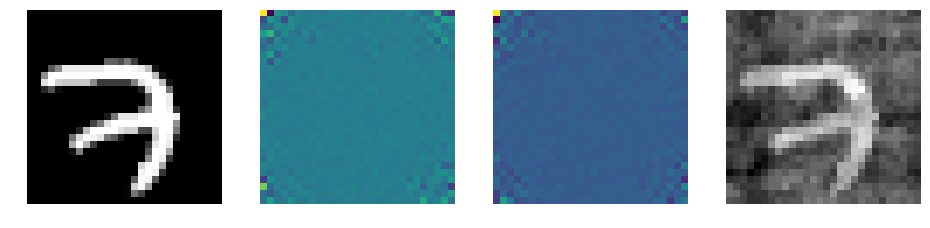

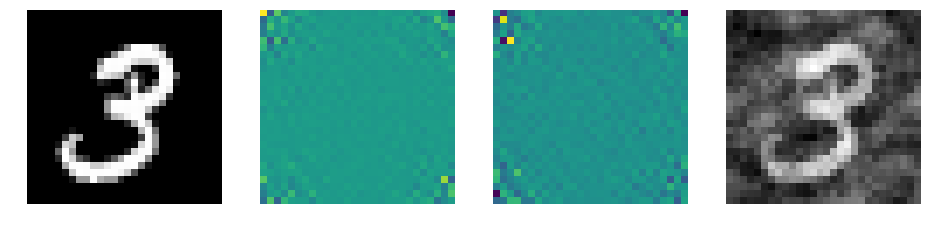

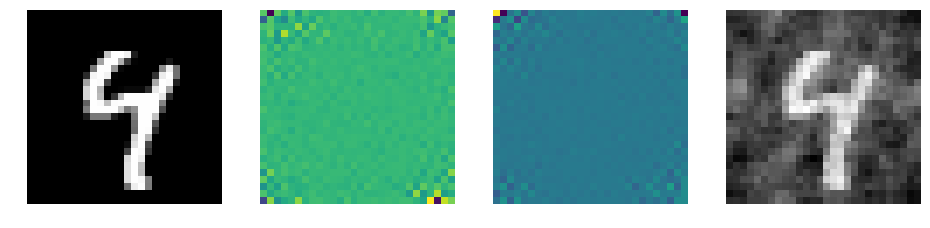

In [60]:
for i in range(3):
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 4, 1)
    plt.imshow(mnist.train.images[i, ...].reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')
    plt.subplot(1, 4, 2)
    plt.imshow(np.real(Y[i]).reshape((28, 28)))
    plt.axis('off')
    plt.subplot(1, 4, 3)
    plt.imshow(np.imag(Y[i]).reshape((28, 28)))
    plt.axis('off')
    plt.subplot(1, 4, 4)
    plt.imshow(np.real(Z[i]).reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')

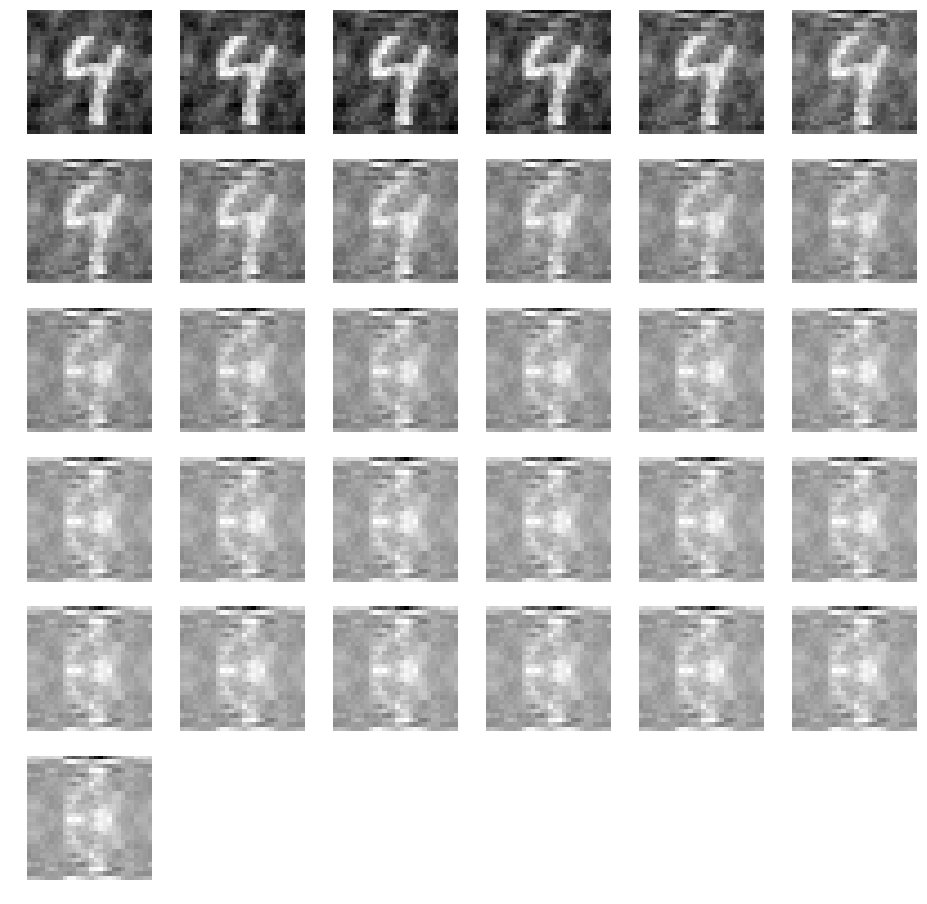

In [63]:
plt.figure(figsize=(16, 16))
for i in range(len(D)):
    plt.subplot(6, 6, i+1)
    plt.imshow(np.real(D[i][2]).reshape((28, 28)), cmap='gray', interpolation='nearest')
    plt.axis('off')